In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV #GridSearch is for hyperparameter tuning
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, PrecisionRecallDisplay, RocCurveDisplay

In [2]:
bikes = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1/main/Datasets/bikes_sharing.csv')

In [3]:
bikes.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


<Axes: xlabel='count', ylabel='Count'>

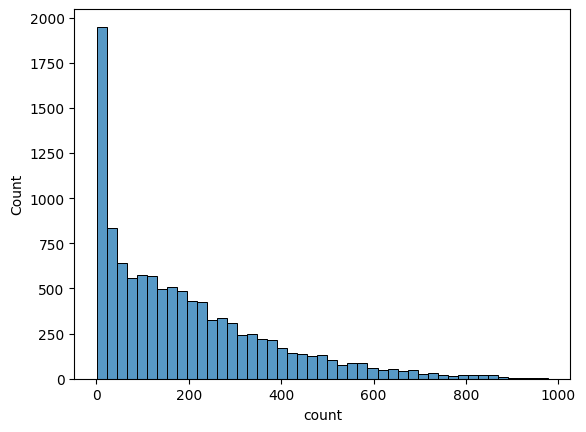

In [4]:
sns.histplot(bikes['count'])

In [5]:
# recreate our time of day values
bikes['datetime'] = pd.to_datetime(bikes['datetime'])

In [6]:
bikes['hour'] = bikes['datetime'].apply(lambda x: x.hour)

In [7]:
# filter for rush hour rentals in the evenings and use that as a proxy for "high number of rentals"
bikes[(bikes['hour'] >= 15) & (bikes['hour']<=19)]['count'].mean()

357.11491228070173

In [8]:
bikes['binary_output'] = bikes['count'].apply(lambda x: 1 if x>=357 else 0)

In [9]:
bikes.groupby('binary_output')['datetime'].count()

binary_output
0    9026
1    1860
Name: datetime, dtype: int64

In [10]:
bikes.groupby('binary_output')['datetime'].count()

binary_output
0    9026
1    1860
Name: datetime, dtype: int64

<Axes: xlabel='hour', ylabel='count'>

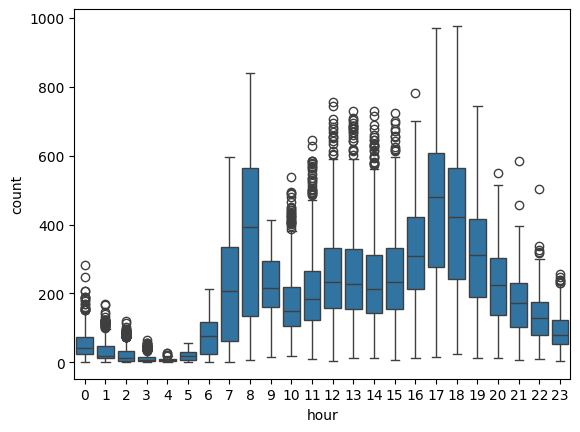

In [11]:
sns.boxplot(x='hour', y='count', data=bikes)

In [12]:
# split data into X variables and y variable
# we are going to predict whether on any given hour, we will rent a HIGH number of bikes (1 = 357+ bikes) OR a LOW number of bikes (0 = <357 bikes)
X = bikes[['season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'hour']]
y = bikes['binary_output']

In [13]:
# reserve 30% for testing
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

In [14]:
MinMaxScaler().fit_transform(bikes[['temp','atemp', 'humidity', 'windspeed']])

array([[0.2244898 , 0.30506768, 0.81      , 0.        ],
       [0.20408163, 0.28806354, 0.8       , 0.        ],
       [0.20408163, 0.28806354, 0.8       , 0.        ],
       ...,
       [0.32653061, 0.33896409, 0.61      , 0.26319502],
       [0.32653061, 0.3728605 , 0.61      , 0.10532503],
       [0.30612245, 0.35585636, 0.66      , 0.15786999]])

In [15]:
# Demostrate OHE
OneHotEncoder().fit_transform(bikes[['season', 'holiday', 'workingday']])

<10886x8 sparse matrix of type '<class 'numpy.float64'>'
	with 32658 stored elements in Compressed Sparse Row format>

In [16]:
# build our pipeline that includes these transformations
numeric_columns = ['temp','atemp', 'humidity', 'windspeed']
categorical_columns = ['season', 'holiday', 'workingday', 'weather']

In [17]:
# create a pre-processing pipeline which includes the steps of Scaling numeric variables and encoding categoricals
preprocessor = ColumnTransformer(
    transformers=[
        ('num',MinMaxScaler(), numeric_columns),
        ('cat',OneHotEncoder(handle_unknown='ignore'),categorical_columns)
    ]
)

In [18]:
# we are going to test 3 models with cross validation to see which ones work best for this data
knn = KNeighborsClassifier()
logreg = LogisticRegression()
nb = GaussianNB()

In [19]:
# cross validation to determine in general which model works best for the given problem
knn_scores = cross_val_score(knn, X_train, y_train, scoring='f1', cv=5)
logreg_scores = cross_val_score(logreg, X_train, y_train, scoring='f1', cv=5)
nb_scores = cross_val_score(nb, X_train, y_train, scoring='f1', cv=5)

c:\Users\NeilXu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\NeilXu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

In [20]:
print(np.mean(knn_scores))
print(np.mean(logreg_scores))
print(np.mean(nb_scores))

0.4484451476892378
0.21623899298057953
0.4759934888351841


In [21]:
# build our pipeline
pipeline = Pipeline(steps=
                    [
                        ('preprocessor',preprocessor),
                        ('classifier',KNeighborsClassifier())
                    ])

In [22]:
# a quick side-quest demo of how KNN works
knn_15 = KNeighborsClassifier(n_neighbors=15).fit(X_train,y_train)
pred_15 = knn_15.predict(X_test)
print(accuracy_score(y_test, pred_15))
print(f1_score(y_test, pred_15))
print(precision_score(y_test, pred_15))
print(recall_score(y_test, pred_15))

0.8573178199632578
0.45433255269320844
0.6576271186440678
0.3470483005366726


In [23]:
# a quick side-quest demo of how KNN works
knn_30 = KNeighborsClassifier(n_neighbors=30).fit(X_train,y_train)
pred_30 = knn_30.predict(X_test)
print(accuracy_score(y_test, pred_30))
print(f1_score(y_test, pred_30))
print(precision_score(y_test, pred_30))
print(recall_score(y_test, pred_30))

0.8551745254133497
0.4005069708491762
0.6869565217391305
0.2826475849731664


In [24]:
#    for our problem
param_grid = {
    'classifier__n_neighbors':[5,7,9,15,35,45,55],
    'classifier__weights':['uniform','distance'],
    'classifier__metric':['euclidean','manhattan','minkowski']
}

In [25]:
# let's perform gridsearch
grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=1, scoring='f1')
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 42 candidates, totalling 210 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['temp',
                                                                          'atemp',
                                                                          'humidity',
                                                                          'windspeed']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['season',
                                                                          'holiday',
                                                                          'workingday',
                                                                          'weather'])])),
                                       ('classifier', KNeighborsClassifier())]),
             param_grid={'classifier__metric': ['euclidean', 'manhattan',
                                                'minkowski'],
                         'classifier__n_neighbors': [5, 7, 9, 15, 35, 45, 55],
                         'classifier__weights': ['uniform', 'distance']},
             scoring='f1', verbose=1)

In [26]:
print(grid_search.best_params_)

{'classifier__metric': 'euclidean', 'classifier__n_neighbors': 7, 'classifier__weights': 'distance'}


In [27]:
final_classifier = KNeighborsClassifier(n_neighbors=grid_search.best_params_['classifier__n_neighbors'],
                                        metric = grid_search.best_params_['classifier__metric'],
                                        weights = grid_search.best_params_['classifier__weights']
                                        )

In [28]:
final_pipeline = Pipeline(steps=
                          [
                              ('preprocessor',preprocessor),
                              ('classifier',final_classifier)
                          ])

In [29]:
final_pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['temp', 'atemp', 'humidity',
                                                   'windspeed']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['season', 'holiday',
                                                   'workingday',
                                                   'weather'])])),
                ('classifier',
                 KNeighborsClassifier(metric='euclidean', n_neighbors=7,
                                      weights='distance'))])

In [30]:
pred = final_pipeline.predict(X_test)

In [31]:
probs = final_pipeline.predict_proba(X_test)

In [32]:
f1_score(y_test, pred)

0.4165733482642777

In [33]:
recall_score(y_test,pred)

0.33273703041144903

In [34]:
accuracy_score(y_test,pred)

0.8404776484996939

In [35]:
precision_score(y_test,pred)

0.5568862275449101